In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models import *
import matplotlib.pyplot as plt
from fastai.metrics import psnr
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
import random
from skimage import io
from PIL import Image

## 0. Downloading the data and taking a look at it

In [2]:
path = untar_data(URLs.IMAGENETTE_160)

In [4]:
img = plt.imread(path/'train/n01440764/n01440764_13464.JPEG')

In [5]:
img.shape

(160, 178, 3)

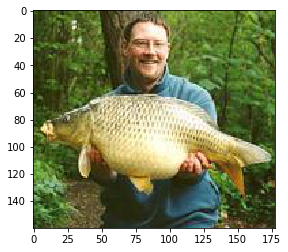

In [6]:
plt.imshow(img)

## 1. Creating the Datasets and Dataloaders

In [3]:
files = os.listdir(path/'train/n01440764')

In [4]:
idx =  random.sample(range(0, len(files)), int(len(files)*0.2))

files_series = pd.Series(files)

files_val = list(files_series.loc[idx])
files_train = list(files_series.drop(idx))

In [6]:
class CustomDataset(Dataset):
    def __init__(self,root, files, window_size=30, tfms=None):
        self.root = root
        self.files = files
        self.window_size=window_size
        self.tfms = tfms
        
    def __len__(self): return len(self.files)
        
    def show(self,idx):
        sample = self.__getitem__(idx)
        #fig=plt.figure(figsize=(5, 5))
        f, ax = plt.subplots(1,2)
        #import pdb;pdb.set_trace()
        stds = np.array([0.229, 0.224, 0.225])
        means = np.array([0.485, 0.456, 0.406])
        x = (sample[0].numpy().transpose((1,2,0))*stds + means)*255
        y = (sample[1].numpy().transpose((1,2,0))*stds + means)*255
        ax[0].imshow(x.astype(np.uint8))
        ax[1].imshow(y.astype(np.uint8))    
        
            
    def __getitem__(self,idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        #import pdb;pdb.set_trace()
        img = io.imread(self.root + '/' + self.files[idx])
        #import pdb;pdb.set_trace()
        #img = img.transpose((2,0,1))
        #img = torch.from_numpy(img)
        
        if self.tfms: 
            #import pdb;pdb.set_trace()
            img = self.tfms(Image.fromarray(img))
            #import pdb;pdb.set_trace()

        
        row_init = np.random.randint(0,img.shape[1]-self.window_size)
        col_init = np.random.randint(0,img.shape[2]-self.window_size)
        #import pdb;pdb.set_trace()
        target = img[:,row_init:row_init+self.window_size,col_init:col_init+self.window_size]
        img_window = img.clone()
        img_window[0,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.485)/0.229
        img_window[1,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.456)/0.224
        img_window[2,row_init:row_init+self.window_size,col_init:col_init+self.window_size] = (0-0.406)/0.225


        sample = (img_window,target)
        
        return sample

In [7]:
tfms = transforms.Compose([
        transforms.RandomResizedCrop(160,scale=(0.8,1)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

In [10]:
train_ds = CustomDataset(str(path)+'/train/n01440764',files_train,tfms=tfms,window_size=32)
valid_ds = CustomDataset(str(path)+'/train/n01440764',files_val,tfms=tfms,window_size=32)

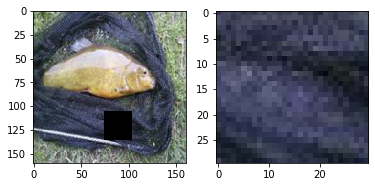

In [13]:
train_ds.show(0)

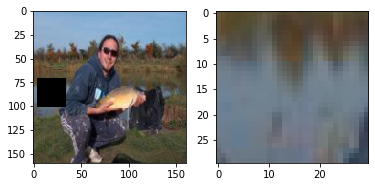

In [15]:
valid_ds.show(0)

In [16]:
train_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)
valid_dl = DataLoader(train_ds, batch_size=16,shuffle=True,num_workers=2)

In [17]:
inputs, classes = next(iter(train_dl))

In [18]:
inputs.shape, classes.shape

(torch.Size([16, 3, 160, 160]), torch.Size([16, 3, 30, 30]))

## 2. Creating the model

In [19]:
mdl = models.resnet18(pretrained=True)

In [20]:
encoder = nn.Sequential(*list(mdl.children())[:-2])

In [21]:
c = encoder(inputs)
c.shape

torch.Size([16, 512, 5, 5])

In [22]:
#Putting a decoder on top of my encoder
fillNet = DynamicUnet(encoder, 3, img_size=(160,160),)

In [27]:
#making shure my outputs match de window size
class LastLayer(nn.Module):
    def __init__(self):
        super(LastLayer,self).__init__()
        self.conv = nn.Conv2d(3,3,(3,3),(5,5),(1,1), bias=False)
        self.bn = nn.BatchNorm2d(3)
    def forward(self,x):
        x = F.relu(self.conv(x))
        return self.bn(x)

In [28]:
fillNet = nn.Sequential(fillNet,LastLayer())

In [29]:
bla = c(inputs)
bla.shape

torch.Size([16, 3, 32, 32])

## 3. Creating the Databunch and Learner

In [0]:
data = DataBunch(train_dl,valid_dl)

In [0]:
learn = Learner(data,fillNet,loss_func=nn.MSELoss(), metrics = [psnr])

In [0]:
#creating the layer groups so that I can use discriminative learning rates
learn.split([learn.model.layers[:4], learn.model.layers[4:8], learn.model.layers[8:]])

In [26]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


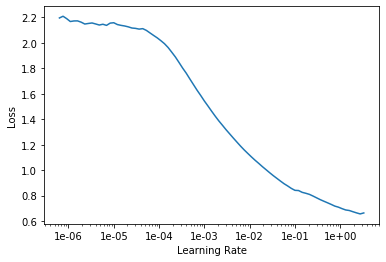

In [27]:
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(20, max_lr=1e-3,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-1')],)

epoch,train_loss,valid_loss,psnr,time
0,0.847102,0.613963,2.145133,00:35
1,0.368917,0.130187,8.877834,00:36
2,0.201171,0.067092,11.766479,00:36
3,0.122447,0.054545,12.651997,00:36
4,0.088550,0.067243,11.859551,00:36
5,0.071596,0.029281,15.351355,00:36
6,0.053092,0.024176,16.206415,00:36
7,0.051290,0.038916,14.113128,00:36
8,0.045372,0.021317,16.741274,00:36
9,0.051698,0.040307,13.996583,00:36


Better model found at epoch 0 with valid_loss value: 0.61396324634552.
Better model found at epoch 1 with valid_loss value: 0.13018694519996643.
Better model found at epoch 2 with valid_loss value: 0.06709233671426773.
Better model found at epoch 3 with valid_loss value: 0.05454457178711891.
Better model found at epoch 5 with valid_loss value: 0.029280606657266617.
Better model found at epoch 6 with valid_loss value: 0.024176083505153656.
Better model found at epoch 8 with valid_loss value: 0.021316736936569214.
Better model found at epoch 10 with valid_loss value: 0.01499904040247202.
Better model found at epoch 15 with valid_loss value: 0.010838625021278858.


In [0]:
def show_results(learn,figsize=(5,5)):
    inputs,classes = next(iter(learn.data.valid_dl))
    preds = learn.model(inputs)
    stds = np.array([0.229, 0.224, 0.225])
    means = np.array([0.485, 0.456, 0.406])
    inp = (inputs[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    target = (classes[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255
    pred = (preds[0].cpu().detach().numpy().transpose((1,2,0))*stds + means)*255

    fig = plt.figure(figsize=figsize)
    ax0 = fig.add_subplot(131)
    ax0.imshow(inp.astype(np.uint8))
    ax0.title.set_text('Input')
    ax1 = fig.add_subplot(132)
    ax1.imshow(target.astype(np.uint8))
    ax1.title.set_text('Target')
    ax2 = fig.add_subplot(133)
    ax2.imshow(pred.astype(np.uint8))
    ax2.title.set_text('Prediction')

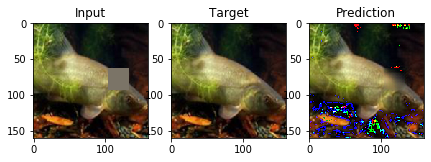

In [36]:
show_results(learn,figsize=(7,7))

In [0]:
learn.load('stage-1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


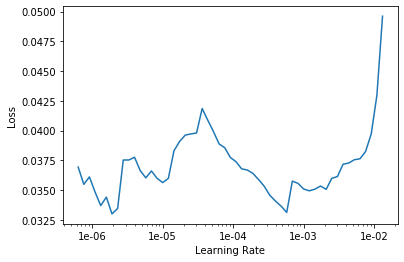

In [38]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(20, 1e-4,
                    callbacks=[callbacks.SaveModelCallback(learn, every='improvement', monitor='valid_loss', name='stage-2')])

epoch,train_loss,valid_loss,psnr,time
0,0.061456,0.022775,16.451038,00:36
1,0.041788,0.011509,19.446661,00:36
2,0.034713,0.011819,19.354696,00:36
3,0.038253,0.011344,19.525177,00:36
4,0.041364,0.015468,18.180511,00:36
5,0.035616,0.011499,19.480122,00:36
6,0.032233,0.010533,19.885117,00:36
7,0.032238,0.012490,19.075045,00:36
8,0.033443,0.011243,19.538507,00:36
9,0.037919,0.012770,19.019171,00:36


Better model found at epoch 0 with valid_loss value: 0.02277510054409504.
Better model found at epoch 1 with valid_loss value: 0.011508663184940815.
Better model found at epoch 3 with valid_loss value: 0.011343586258590221.
Better model found at epoch 6 with valid_loss value: 0.010533246211707592.


KeyboardInterrupt: ignored